In [20]:
import os
import glob
from PIL import Image
import torch
import torchvision.transforms as T
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision.transforms.functional as TF
import random

In [21]:
class BFSDataset(Dataset):
    def __init__(self, scene_names, root_dir='../data', transform=None, resize=(480, 720)):
        """
        Args:
            scene_names (list of str): List of scene names representing different camera directions.
            root_dir (str): Root directory containing 'Images' and 'Annotations' folders.
            transform (callable, optional): Optional transform to be applied on a sample.
            resize (tuple): Desired output size (height, width).
        """
        self.root_dir = root_dir
        self.scene_names = scene_names
        self.transform = transform
        self.resize = resize  # Desired size (H, W)

        self.img_paths = []
        self.ann_paths = []
        self.scene_labels = []  # To track the scene for each image

        for scene in self.scene_names:
            img_dir = os.path.join(root_dir, 'Images', scene)
            ann_dir = os.path.join(root_dir, 'Annotations', scene)

            # Gather all image paths and sort for consistency
            scene_img_paths = glob.glob(os.path.join(img_dir, '*', '*.jpg'))
            scene_img_paths.sort()
            self.img_paths.extend(scene_img_paths)

            # Derive annotation paths using corresponding directory and filename
            for img_path in scene_img_paths:
                relative = os.path.relpath(img_path, img_dir)  # e.g., <date>/<timestamp>.jpg
                ann_path = os.path.join(ann_dir, relative[:-4] + '.png')  # replace .jpg with .png
                self.ann_paths.append(ann_path)
                self.scene_labels.append(scene)  # Append scene label

        # Define transforms
        self.img_transform = T.Compose([
            T.Resize(self.resize),
            T.ToTensor()
        ])
        self.ann_transform = T.Compose([
            T.Resize(self.resize, interpolation=Image.NEAREST),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # Load image and annotation
        img_path = self.img_paths[idx]
        ann_path = self.ann_paths[idx]

        image = Image.open(img_path).convert("RGB")
        annotation = Image.open(ann_path)

        # Apply transforms
        image = self.img_transform(image)
        annotation = self.ann_transform(annotation)
        annotation = torch.as_tensor(annotation.squeeze(), dtype=torch.long)

        # Apply additional transformations if any
        if self.transform:
            image, annotation = self.transform(image, annotation)

        return image, annotation.unsqueeze(0).float()

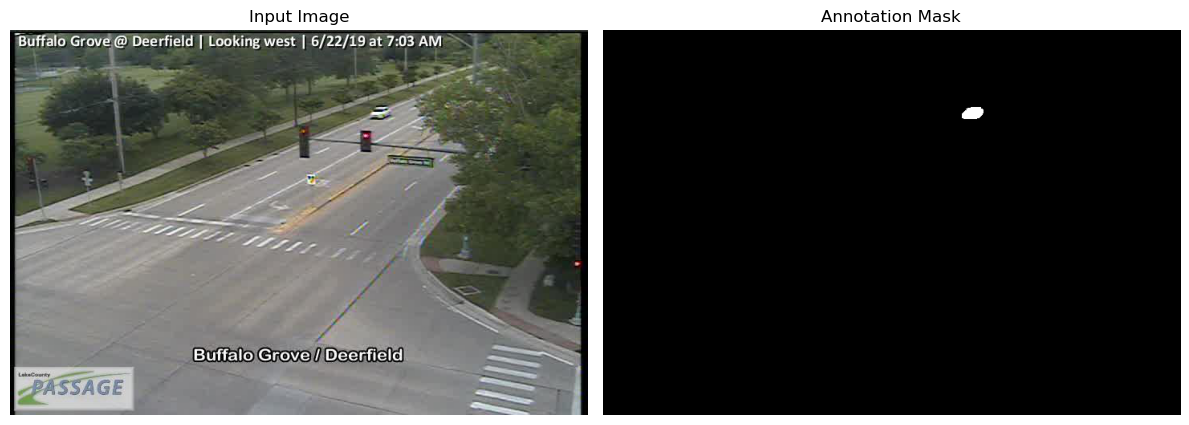

In [38]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Assuming BFSDataset is already defined and imported
# and includes all four directions as per your previous setup

# Define the four camera directions
directions = [
    'Buffalo Grove at Deerfield East', 
    'Buffalo Grove at Deerfield West',
    'Buffalo Grove at Deerfield North',
    'Buffalo Grove at Deerfield South'
]

# Instantiate the dataset with all four directions
full_dataset = BFSDataset(
    scene_names=directions, 
    root_dir='../data', 
    resize=(480, 720)  # Ensure consistent resizing
)

# Function to visualize a random sample from the dataset
def visualize_random_sample(dataset):
    # Select a random index
    random_idx = np.random.randint(0, len(dataset))
    
    # Retrieve the image and mask
    image, mask = dataset[random_idx]
    
    # Convert image tensor to NumPy array and transpose to (H, W, C)
    image_np = image.permute(1, 2, 0).numpy()
    
    # Convert mask tensor to NumPy array
    mask_np = mask.squeeze(0).numpy()
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display the input image
    axes[0].imshow(image_np)
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    
    # Display the annotation mask
    axes[1].imshow(mask_np, cmap='gray')
    axes[1].set_title('Annotation Mask')
    axes[1].axis('off')
    
    # Show the plots
    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_random_sample(full_dataset)

In [39]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=2),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU(),
                                     nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU(),
                                     nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2),
                                     nn.BatchNorm2d(256),
                                     nn.ReLU())
        self.decoder = nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU())
        self.outconv = nn.Conv2d(64, 1, kernel_size=1, padding=0, stride=1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        # Encode
        x = self.encoder(x)

        # Decode
        x = self.decoder(x)

        # Classify
        x = self.outconv(x)

        return self.activation(x)

In [29]:
def iou(model, dataloader, device='cpu'):
    '''
    model: Instance of a PyTorch nn.Module class with a defined forward() function that takes images as inputs
    dataloader: PyTorch DataLoader object that represents the dataset we will compute IoU over
    device (optional): string naming the device for computation, only needs to be changed for GPU training/evaluation
    '''
    intersection_pixel_count = 0
    union_pixel_count = 0
    with torch.no_grad():
        for images, targets in dataloader:
            # images should be shape (N, 3, H, W) for N images in a batch
            # targets should be shape (N, 1, H, W) for N images in a batch
            images, targets = images.to(device), targets.to(device)
            predictions = model(images)
            # predictions may be shape (N, 1, H, W) or (N, 2, H, W) depending on choice of implementation and loss function
            if predictions.size(1) == 1:
                # single prediction channel, result from model already passed through sigmoid
                binary_predictions = predictions > 0.5 # set pixels with >0.5 probability to one
            else:
                # two prediction channels, index 1 represents positive/foreground class, need to pass through softmax first
                prediction_probabilities = torch.softmax(predictions, dim=1)
                binary_predictions = prediction_probabilities[:, 1] > 0.5
                binary_predictions = binary_predictions.unsqueeze(1) # return to shape (N, 1, H, W)
            # add to intersection and union counts
            intersection_pixel_count += torch.sum((binary_predictions*targets)>0).item()
            union_pixel_count += torch.sum((binary_predictions+targets)>0).item()
    # return IoU over the given dataset
    return intersection_pixel_count/union_pixel_count

In [30]:
def compute_class_weights(dataset, num_classes=2):
    """
    Computes class weights inversely proportional to class frequencies.
    Args:
        dataset (Dataset): PyTorch dataset.
        num_classes (int): Number of classes.
    Returns:
        torch.Tensor: Weights for each class.
    """
    class_counts = torch.zeros(num_classes)
    for _, target in dataset:
        for c in range(num_classes):
            class_counts[c] += torch.sum(target == c).item()

    # Avoid division by zero
    class_counts += 1e-6

    # Compute weights: inverse frequency
    class_weights = 1.0 / class_counts

    # Normalize weights
    class_weights = class_weights / class_weights.sum() * num_classes

    return class_weights

In [31]:
def training_loop(model, train_dataloader, validation_dataloader, optimizer, criterion, n_epochs=10, device='cpu'):
    model = model.to(device)
    metrics = {
        'train_loss': [],
        'train_iou': [],
        'val_iou': []
    }

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0

        for images, targets in train_dataloader:
            # Move to device if using GPU
            images, targets = images.to(device), targets.to(device)
            
            # Zero out gradients
            optimizer.zero_grad()
            
            # Forward pass
            predictions = model(images)
            
            # Compute loss
            # loss = criterion(predictions, targets.squeeze(1)) 
            loss = criterion(predictions, targets) 
            
            # Backprop and update weights
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Compute average training loss for this epoch
        avg_train_loss = running_loss / len(train_dataloader)
        metrics['train_loss'].append(avg_train_loss)

        # Evaluate training IoU
        model.eval()
        train_iou = iou(model, train_dataloader, device=device)
        metrics['train_iou'].append(train_iou)

        # Evaluate validation IoU
        val_iou = iou(model, validation_dataloader, device=device)
        metrics['val_iou'].append(val_iou)

        print(f"Epoch [{epoch+1}/{n_epochs}] - Train Loss: {avg_train_loss:.4f}, Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f}")
        
    return model, metrics

Epoch [1/400] - Train Loss: 0.6008, Train IoU: 0.0000, Val IoU: 0.0000
Epoch [2/400] - Train Loss: 0.2306, Train IoU: 0.0000, Val IoU: 0.0000
Epoch [3/400] - Train Loss: 0.1485, Train IoU: 0.0000, Val IoU: 0.0000
Epoch [4/400] - Train Loss: 0.1568, Train IoU: 0.0000, Val IoU: 0.0000
Epoch [5/400] - Train Loss: 0.2056, Train IoU: 0.0000, Val IoU: 0.0000
Epoch [6/400] - Train Loss: 0.1842, Train IoU: 0.0000, Val IoU: 0.0000
Epoch [7/400] - Train Loss: 0.1895, Train IoU: 0.0000, Val IoU: 0.0000
Epoch [8/400] - Train Loss: 0.1452, Train IoU: 0.0000, Val IoU: 0.0000
Epoch [9/400] - Train Loss: 0.1145, Train IoU: 0.0000, Val IoU: 0.0000
Epoch [10/400] - Train Loss: 0.1047, Train IoU: 0.0000, Val IoU: 0.0000
Epoch [11/400] - Train Loss: 0.0996, Train IoU: 0.0000, Val IoU: 0.0000
Epoch [12/400] - Train Loss: 0.0986, Train IoU: 0.0000, Val IoU: 0.0000
Epoch [13/400] - Train Loss: 0.0953, Train IoU: 0.0000, Val IoU: 0.0000
Epoch [14/400] - Train Loss: 0.0885, Train IoU: 0.0000, Val IoU: 0.0000
E

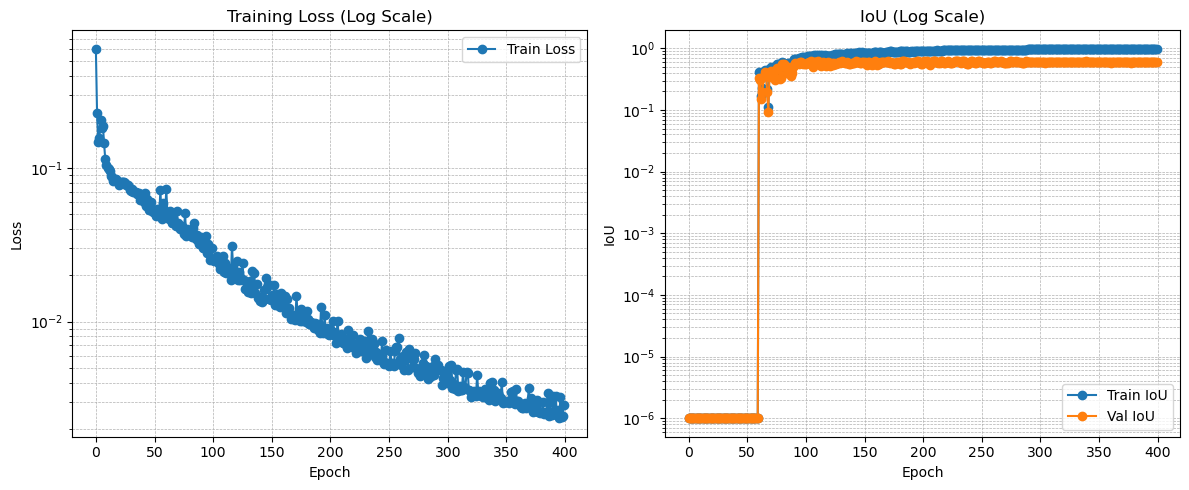

In [32]:
import random
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim

# Seed for reproducibility
random.seed(42)

# Instantiate the dataset
# directions = [
#     'Buffalo Grove at Deerfield East', 
#     'Buffalo Grove at Deerfield West',
#     'Buffalo Grove at Deerfield North',
#     'Buffalo Grove at Deerfield South'
# ]
directions = [
    'Buffalo Grove at Deerfield East', 
]
full_dataset = BFSDataset(
    scene_names=directions, 
    root_dir='../data', 
    # resize=(480, 720),
    resize=(240, 360),
    transform=None  # Add your augmentations here if needed
)

# Split dataset into half training and half validation per scene
train_indices = []
val_indices = []

for scene in directions:
    # Get all indices for the current scene
    scene_indices = [i for i, s in enumerate(full_dataset.scene_labels) if s == scene]
    
    # Shuffle the indices
    random.shuffle(scene_indices)
    
    # Split half for training and half for validation
    split = len(scene_indices) // 2
    train_indices.extend(scene_indices[:split])
    val_indices.extend(scene_indices[split:])

# Create Subset datasets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

# Instantiate model, optimizer, and loss function
model = SegmentationModel()  # Ensure SegmentationModel is defined earlier
class_weights = compute_class_weights(train_dataset, num_classes=2)  # Ensure compute_class_weights is defined
# criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=255)
criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.99, weight_decay=1e-5)

# Move model to device
model.to(device="cpu")

# Train the model
model, metrics = training_loop(
    model, 
    train_loader, 
    val_loader, 
    optimizer, 
    criterion, 
    n_epochs=400, 
    device="cpu"
)

# Plot the training loss and IoU values
epsilon = 1e-6

train_iou = np.array(metrics['train_iou']) + epsilon
val_iou = np.array(metrics['val_iou']) + epsilon

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(metrics['train_loss'], label='Train Loss', marker='o')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Training Loss (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.subplot(1, 2, 2)
plt.plot(train_iou, label='Train IoU', marker='o')
plt.plot(val_iou, label='Val IoU', marker='o')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('IoU (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

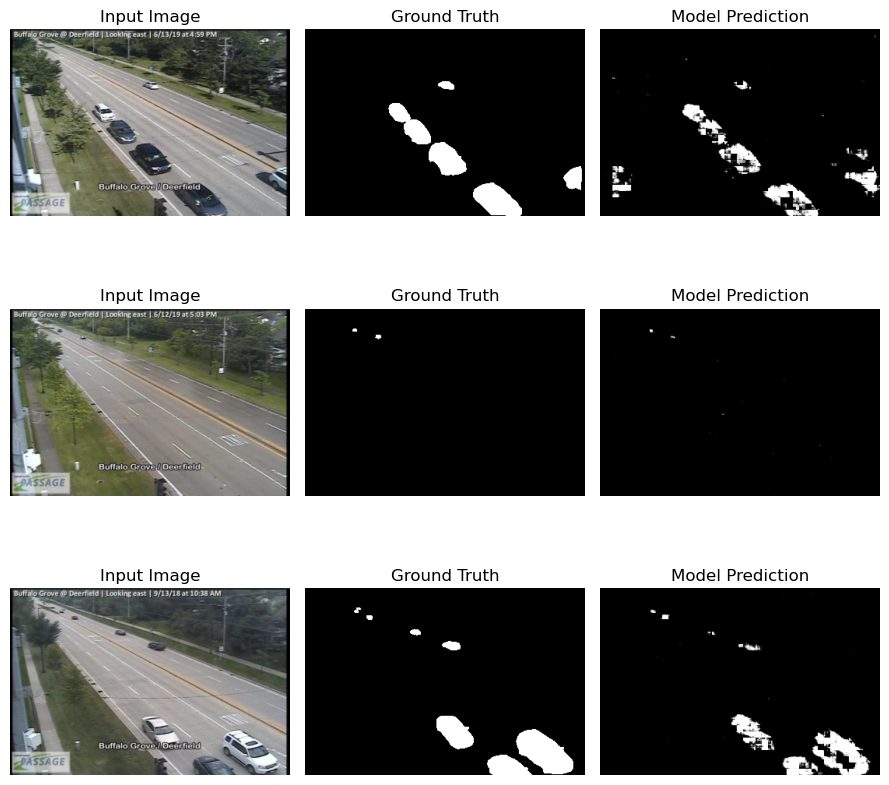

In [33]:
# Switch to evaluation mode and visualize a few predictions from the validation set
model.eval()
with torch.no_grad():
    val_iter = iter(val_loader)
    images, targets = next(val_iter)  # get a batch of images
    predictions = model(images)

    # # If model outputs shape (N,2,H,W), apply softmax and take the foreground channel
    # prediction_prob = torch.softmax(predictions, dim=1)[:,1] # foreground probabilities
    # binary_preds = (prediction_prob > 0.5).cpu().numpy()  # convert to numpy
    binary_preds = predictions

# Display a few samples
fig, axes = plt.subplots(3, 3, figsize=(9,9))
for i in range(3):
    img = images[i].cpu().numpy().transpose(1,2,0)  # (C,H,W) -> (H,W,C)
    img = np.clip(img,0,1) # ensure proper range for plotting
    target_mask = targets[i].cpu().numpy().squeeze() # (H,W)
    pred_mask = binary_preds[i].squeeze(0)

    axes[i,0].imshow(img)
    axes[i,0].set_title('Input Image')
    axes[i,0].axis('off')

    axes[i,1].imshow(target_mask, cmap='gray')
    axes[i,1].set_title('Ground Truth')
    axes[i,1].axis('off')

    axes[i,2].imshow(pred_mask, cmap='gray')
    axes[i,2].set_title('Model Prediction')
    axes[i,2].axis('off')

plt.tight_layout()
plt.show()

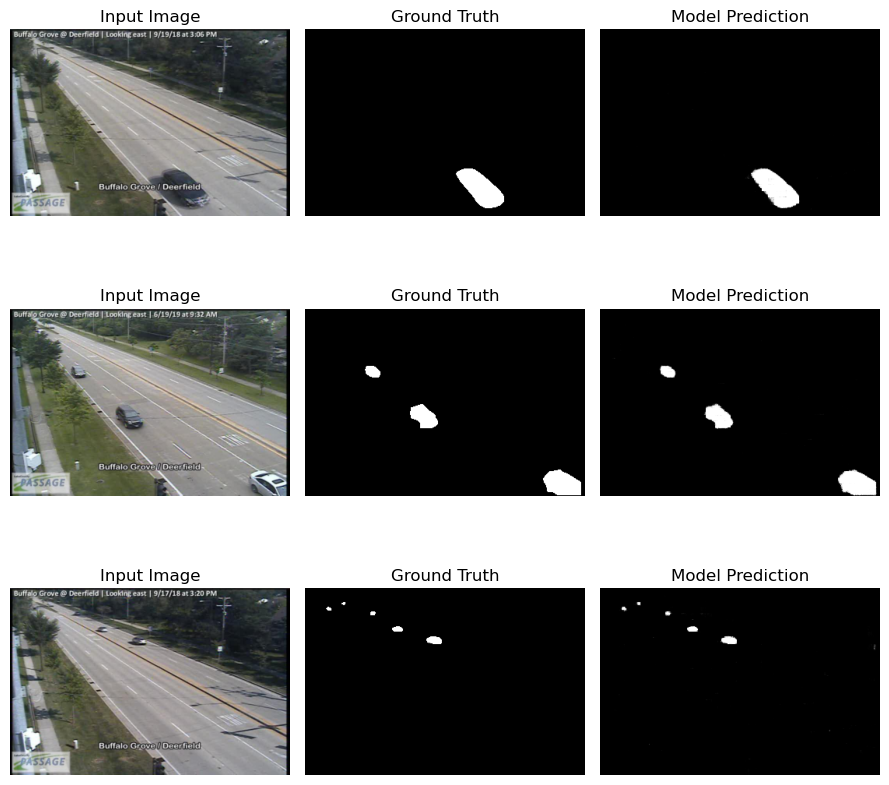

In [34]:
# Switch to evaluation mode and visualize a few predictions from the training set
model.eval()
with torch.no_grad():
    train_iter = iter(train_loader)
    images, targets = next(train_iter)  # get a batch of images
    predictions = model(images)

    # # If model outputs shape (N,2,H,W), apply softmax and take the foreground channel
    # prediction_prob = torch.softmax(predictions, dim=1)[:,1] # foreground probabilities
    # binary_preds = (prediction_prob > 0.5).cpu().numpy()  # convert to numpy
    binary_preds = predictions

# Display a few samples
fig, axes = plt.subplots(3, 3, figsize=(9,9))
for i in range(3):
    img = images[i].cpu().numpy().transpose(1,2,0)  # (C,H,W) -> (H,W,C)
    img = np.clip(img,0,1) # ensure proper range for plotting
    target_mask = targets[i].cpu().numpy().squeeze() # (H,W)
    pred_mask = binary_preds[i].squeeze(0)

    axes[i,0].imshow(img)
    axes[i,0].set_title('Input Image')
    axes[i,0].axis('off')

    axes[i,1].imshow(target_mask, cmap='gray')
    axes[i,1].set_title('Ground Truth')
    axes[i,1].axis('off')

    axes[i,2].imshow(pred_mask, cmap='gray')
    axes[i,2].set_title('Model Prediction')
    axes[i,2].axis('off')

plt.tight_layout()
plt.show()